In [1]:
# 2. Imports
import os
import shutil
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet169, preprocess_input
from tensorflow.keras import layers, models, optimizers, callbacks
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
# 3. Paths & Parameters
BASE_DIR = '/content/drive/MyDrive/wrist_xray_DenseNet169'
train_dir = os.path.join(BASE_DIR, 'train')
val_dir = os.path.join(BASE_DIR, 'val')

IMG_SIZE = (224, 224)  # DenseNet169 input size
BATCH_SIZE = 32
VAL_SPLIT = 0.2
SEED = 42

In [4]:
# 4. Create train/val folders (same structure)
for split_dir in [train_dir, val_dir]:
    for cls in ['Normal', 'Fracture']:
        os.makedirs(os.path.join(split_dir, cls), exist_ok=True)

In [5]:
# 5. Split & copy images
for cls in ['Normal', 'Fracture']:
    src = os.path.join(BASE_DIR, cls)
    imgs = [f for f in os.listdir(src) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    train_imgs, val_imgs = train_test_split(imgs, test_size=VAL_SPLIT, random_state=SEED)

    for fname in train_imgs:
        shutil.copy(os.path.join(src, fname), os.path.join(train_dir, cls, fname))
    for fname in val_imgs:
        shutil.copy(os.path.join(src, fname), os.path.join(val_dir, cls, fname))
print("✅ Dataset split into train/val folders")


✅ Dataset split into train/val folders


In [6]:
# 6. Data Generators & Augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='reflect'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=SEED
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 153 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [7]:
# 7. Compute Class Weights
counts = Counter(train_gen.classes)
total = sum(counts.values())
class_weight = {k: total/(2*v) for k,v in counts.items()}
print("Class weights:", class_weight)


Class weights: {0: 0.8693181818181818, 1: 1.176923076923077}


In [8]:
# 8. Build DenseNet169 Model
def build_model():
    base_model = DenseNet169(
        weights='imagenet',
        include_top=False,
        input_shape=(*IMG_SIZE, 3)
    )
    base_model.trainable = False

    inputs = layers.Input(shape=(*IMG_SIZE, 3))
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    return models.Model(inputs, outputs)

model = build_model()
model.summary()

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet169 (Functional)             │ (None, 7, 7, 1664)          │      12,642,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1664)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1664)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         426,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,069,377 (49.86 MB)

 Trainable params: 426,497 (1.63 MB)

 Non-trainable params: 12,642,880 (48.23 MB)

In [9]:
# 9. Compile & Callbacks
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

callbacks = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    callbacks.ModelCheckpoint('best_densenet169.h5', save_best_only=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

In [10]:
# 10. Train Head
history_head = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    class_weight=class_weight,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5478 - loss: 0.9388 - precision: 0.5326 - recall: 0.6993

5/5 ━━━━━━━━━━━━━━━━━━━━ 94s 13s/step - accuracy: 0.5524 - loss: 0.9399 - precision: 0.5271 - recall: 0.6751 - val_accuracy: 0.6250 - val_loss: 0.5885 - val_precision: 1.0000 - val_recall: 0.1176 - learning_rate: 0.0010
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step - accuracy: 0.6705 - loss: 0.6650 - precision: 0.5232 - recall: 0.4785 - val_accuracy: 0.6500 - val_loss: 0.7422 - val_precision: 0.5484 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.8103 - loss: 0.3813 - precision: 0.7102 - recall: 0.9312

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 859ms/step - accuracy: 0.8093 - loss: 0.3845 - precision: 0.7152 - recall: 0.9144 - val_accuracy: 0.9250 - val_loss: 0.2666 - val_precision: 0.8889 - val_recall: 0.9412 - learning_rate: 0.0010
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step - accuracy: 0.7987 - loss: 0.4387 - precision: 0.8475 - recall: 0.7272 - val_accuracy: 0.7500 - val_loss: 0.4538 - val_precision: 0.6296 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.8227 - loss: 0.3829 - precision: 0.7225 - recall: 0.9384

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 973ms/step - accuracy: 0.8283 - loss: 0.3743 - precision: 0.7345 - recall: 0.9307 - val_accuracy: 0.9000 - val_loss: 0.2448 - val_precision: 0.8095 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.8760 - loss: 0.2601 - precision: 0.8368 - recall: 0.9099

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 841ms/step - accuracy: 0.8803 - loss: 0.2583 - precision: 0.8402 - recall: 0.9121 - val_accuracy: 0.9000 - val_loss: 0.2332 - val_precision: 0.8095 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.9190 - loss: 0.2179 - precision: 0.8675 - recall: 0.9527

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 973ms/step - accuracy: 0.9183 - loss: 0.2192 - precision: 0.8719 - recall: 0.9452 - val_accuracy: 0.9500 - val_loss: 0.1971 - val_precision: 0.8947 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.8991 - loss: 0.2451 - precision: 0.8796 - recall: 0.8929

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8996 - loss: 0.2441 - precision: 0.8758 - recall: 0.8980 - val_accuracy: 0.9250 - val_loss: 0.1917 - val_precision: 0.8500 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.8833 - loss: 0.2666 - precision: 0.8974 - recall: 0.8699

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 858ms/step - accuracy: 0.8864 - loss: 0.2608 - precision: 0.8963 - recall: 0.8711 - val_accuracy: 0.9250 - val_loss: 0.1874 - val_precision: 0.8500 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 600ms/step - accuracy: 0.8796 - loss: 0.2919 - precision: 0.8358 - recall: 0.8878 - val_accuracy: 0.9000 - val_loss: 0.2314 - val_precision: 0.8095 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.9308 - loss: 0.1645 - precision: 0.8533 - recall: 0.9872

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 940ms/step - accuracy: 0.9303 - loss: 0.1655 - precision: 0.8552 - recall: 0.9868 - val_accuracy: 0.9500 - val_loss: 0.1403 - val_precision: 0.9412 - val_recall: 0.9412 - learning_rate: 0.0010
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.8984 - loss: 0.1844 - precision: 0.8861 - recall: 0.8897

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 980ms/step - accuracy: 0.9023 - loss: 0.1827 - precision: 0.8897 - recall: 0.8927 - val_accuracy: 0.9500 - val_loss: 0.1296 - val_precision: 0.9412 - val_recall: 0.9412 - learning_rate: 0.0010
Epoch 13/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step - accuracy: 0.9314 - loss: 0.2663 - precision: 0.9208 - recall: 0.9207 - val_accuracy: 0.8250 - val_loss: 0.3276 - val_precision: 0.7083 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 14/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 586ms/step - accuracy: 0.9380 - loss: 0.1357 - precision: 0.8698 - recall: 1.0000 - val_accuracy: 0.9750 - val_loss: 0.1304 - val_precision: 0.9444 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 15/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.9469 - loss: 0.1405 - precision: 0.9367 - recall: 0.9264

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9459 - loss: 0.1429 - precision: 0.9368 - recall: 0.9259 - val_accuracy: 0.9500 - val_loss: 0.1088 - val_precision: 0.9412 - val_recall: 0.9412 - learning_rate: 0.0010
Epoch 16/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 576ms/step - accuracy: 0.9150 - loss: 0.1621 - precision: 0.9034 - recall: 0.8953 - val_accuracy: 0.8750 - val_loss: 0.2875 - val_precision: 0.7727 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 17/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.9222 - loss: 0.1446 - precision: 0.8470 - recall: 0.9969

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 858ms/step - accuracy: 0.9232 - loss: 0.1469 - precision: 0.8500 - recall: 0.9949 - val_accuracy: 0.9500 - val_loss: 0.1016 - val_precision: 0.9412 - val_recall: 0.9412 - learning_rate: 0.0010
Epoch 18/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 715ms/step - accuracy: 0.9449 - loss: 0.1620 - precision: 0.9910 - recall: 0.8774 - val_accuracy: 0.9500 - val_loss: 0.1027 - val_precision: 0.9412 - val_recall: 0.9412 - learning_rate: 0.0010
Epoch 19/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 615ms/step - accuracy: 0.9446 - loss: 0.1495 - precision: 0.9443 - recall: 0.9177 - val_accuracy: 0.9250 - val_loss: 0.1889 - val_precision: 0.8500 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 20/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.9310 - loss: 0.2076 - precision: 0.8998 - recall: 0.9418

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 856ms/step - accuracy: 0.9327 - loss: 0.2033 - precision: 0.9039 - recall: 0.9412 - val_accuracy: 0.9500 - val_loss: 0.1014 - val_precision: 0.9412 - val_recall: 0.9412 - learning_rate: 0.0010
Epoch 21/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.9577 - loss: 0.1553 - precision: 0.9602 - recall: 0.9391

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9593 - loss: 0.1500 - precision: 0.9641 - recall: 0.9390 - val_accuracy: 0.9500 - val_loss: 0.1011 - val_precision: 0.9412 - val_recall: 0.9412 - learning_rate: 0.0010
Epoch 22/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 571ms/step - accuracy: 0.9713 - loss: 0.0770 - precision: 0.9399 - recall: 0.9949 - val_accuracy: 0.9750 - val_loss: 0.1253 - val_precision: 0.9444 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 23/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.9838 - loss: 0.1080 - precision: 0.9645 - recall: 1.0000

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 855ms/step - accuracy: 0.9833 - loss: 0.1089 - precision: 0.9631 - recall: 1.0000 - val_accuracy: 0.9500 - val_loss: 0.0960 - val_precision: 0.9412 - val_recall: 0.9412 - learning_rate: 0.0010
Epoch 24/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 584ms/step - accuracy: 0.9672 - loss: 0.1214 - precision: 0.9591 - recall: 0.9626 - val_accuracy: 0.9500 - val_loss: 0.1120 - val_precision: 1.0000 - val_recall: 0.8824 - learning_rate: 0.0010
Epoch 25/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 859ms/step - accuracy: 0.9244 - loss: 0.1456 - precision: 0.9372 - recall: 0.8814 - val_accuracy: 0.9750 - val_loss: 0.1301 - val_precision: 0.9444 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 26/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 573ms/step - accuracy: 0.9291 - loss: 0.1768 - precision: 0.8771 - recall: 0.9773 - val_accuracy: 0.9500 - val_loss: 0.1295 - val_precision: 1.0000 - val_recall: 0.8824 - learning_rate: 0.0010
Epoch 27/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 583ms/step - accuracy: 0.9237 - loss: 0.

In [11]:
# 11. Fine-Tuning Phase
# Unfreeze last 50 layers
model.trainable = True
for layer in model.layers[1].layers[:-50]:  # Keep BatchNorm layers frozen
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    initial_epoch=history_head.epoch[-1],
    class_weight=class_weight,
    callbacks=callbacks
)

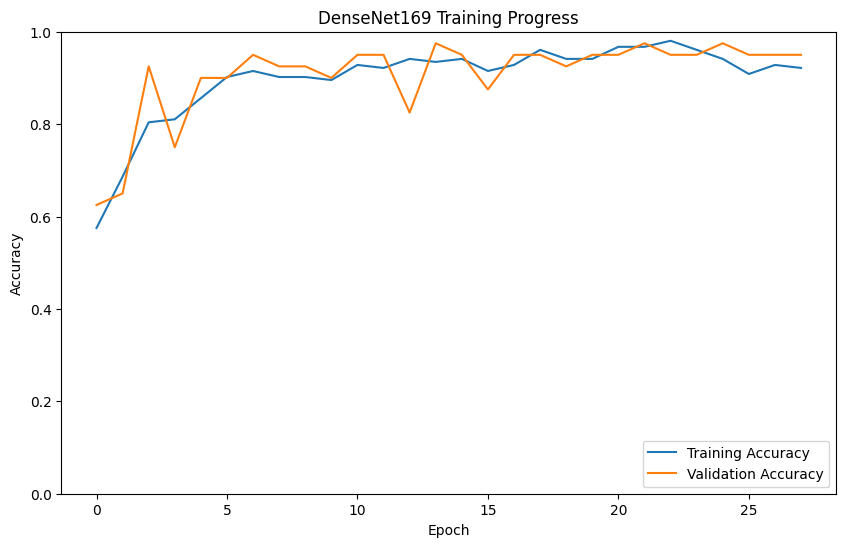

In [12]:
# 12. Version-safe Plotting
def plot_history(histories):
    key_mapping = {
        'train_acc': ['accuracy', 'acc'],
        'val_acc': ['val_accuracy', 'val_acc']
    }

    train_acc = []
    for hist in histories:
        for key in key_mapping['train_acc']:
            if key in hist.history:
                train_acc += hist.history[key]
                break

    val_acc = []
    for hist in histories:
        for key in key_mapping['val_acc']:
            if key in hist.history:
                val_acc += hist.history[key]
                break

    plt.figure(figsize=(10, 6))
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.title('DenseNet169 Training Progress')
    plt.show()

plot_history([history_head, history_fine])

In [13]:
# 13. Evaluation & Saving
model.load_weights('best_densenet169.h5')
loss, acc = model.evaluate(val_gen)
print(f"\n✅ Final Validation Accuracy: {acc*100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 31s 10s/step - accuracy: 0.9563 - loss: 0.0853

✅ Final Validation Accuracy: 95.00%


In [14]:
def save_model_safely(model, final_path):
    """Saves model safely for Keras 3.x compatibility"""
    # 1. Create temporary paths
    weights_path = final_path.replace('.h5', '.weights.h5')  # Must end with .weights.h5
    arch_path = final_path.replace('.h5', '_arch.json')

    # 2. Save components separately
    model.save_weights(weights_path)
    with open(arch_path, 'w') as f:
        f.write(model.to_json())

    # 3. Reconstruct and save properly
    reconstructed = tf.keras.models.model_from_json(
        open(arch_path).read(),
        custom_objects={'DenseNet169': DenseNet169}  # Include custom objects
    )
    reconstructed.load_weights(weights_path)
    reconstructed.save(final_path)

    # 4. Cleanup temp files
    os.remove(weights_path)
    os.remove(arch_path)
    print(f"✅ Model saved successfully: {final_path} ({os.path.getsize(final_path)/1e6:.1f} MB)")

# Usage
save_model_safely(model, '/content/drive/MyDrive/densenet169_wrist_model_safe.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


✅ Model saved successfully: /content/drive/MyDrive/densenet169_wrist_model_safe.h5 (56.9 MB)


In [15]:
# Check the saved model
dense_path = '/content/drive/MyDrive/densenet169_wrist_model_safe.h5'
print(f"File exists: {os.path.exists(dense_path)}")
print(f"File size: {os.path.getsize(dense_path)/1e6:.1f} MB")

# Try loading
densenet = tf.keras.models.load_model(
    dense_path,
    custom_objects={'DenseNet169': DenseNet169}
)
print("✅ Model loaded successfully!")

File exists: True
File size: 56.9 MB


✅ Model loaded successfully!


In [16]:
# 15. Prediction Function
def predict_single_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0][0]
    label = 'Fracture' if prediction < 0.5 else 'Normal'

    plt.imshow(img)
    plt.title(f"DenseNet169 Prediction: {label} ({prediction:.4f})")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step


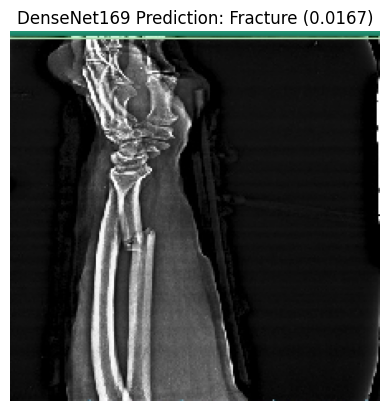

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


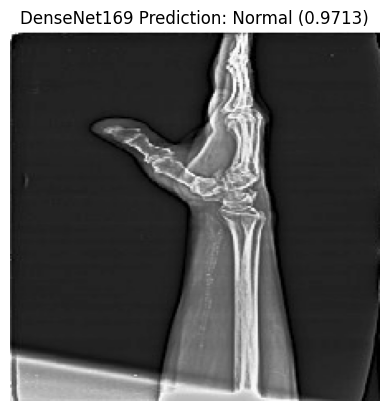

In [17]:
# Test prediction
predict_single_image('/content/drive/MyDrive/wrist_xray_DenseNet169/Fracture/3 Male (L View).jpg')
predict_single_image('/content/drive/MyDrive/wrist_xray_DenseNet169/Normal/1.jpg')
